## ZX simulation validation

Performs a set of efficiency, acceptance, and resolution plots based on the ZX toy MC samples

The notebook runs with the 96, 97 (python3 preferentially) software stack in SWAN

In [1]:
import ROOT
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot configurations
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetPadBottomMargin(0.1)
ROOT.gStyle.SetPadLeftMargin(0.12)
ROOT.gStyle.SetPadTopMargin(0.05)
ROOT.gStyle.SetPadRightMargin(0.03)

outdir='/eos/user/p/psilva/www/ExclusiveAna_2017_unblind_multi/signal'

#prepare output directory
import os
os.system('mkdir -p %s'%outdir)

#available info
masses=[600,800,1000,1200,1400,1600]
sides=['Pos','Neg']
titles={'multi':'multiRP','pix':'Pixels','strip':'Strips'}
ms={'multi':20,'pix':26,'strip':32}
algos=titles.keys()

vtitles={'mpp':'m(pp) [GeV]',
         'pzpp':'$p_{z}$(pp) [GeV]',
        }
vlist=vtitles.keys()
effbins={'mpp':np.linspace(0,2000,100),'pzpp':np.linspace(-2500,2500,100),'xi':np.linspace(0,0.2,100)}

fillGraphs=True

# read the data to memory
rdf = ROOT.RDataFrame("tuple", "/eos/cms/store/cmst3/group/top/PPSZX/ZX_validation.root")
df=pd.DataFrame(rdf.AsNumpy())
df=df.rename(columns={"gen_pzpp": "pzpp_gen"})
df.head()

Welcome to JupyROOT 6.20/02


/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/ROOT.py:421: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  result_ptrs[column] = _root.ROOT.Internal.RDF.RDataFrameTake(column_type)(df_rnode, column)


,mX,xangle,postTS2,wgt,pzpp_gen,csiNeg_gen,csiPos_gen,mpp_gen,mmass_gen,csiNeg_multi,...,mpp_multi,mmass_multi,csiNeg_pix,csiPos_pix,mpp_pix,mmass_pix,csiNeg_strip,csiPos_strip,mpp_strip,mmass_strip
0,600.0,120.0,0.0,4.516446e-13,1367.842407,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,600.0,120.0,0.0,1.284326e-12,574.560486,0.114020,0.025626,702.701843,600.0,0.113740,...,-1.0,-1.0,0.123893,0.025863,735.871399,632.268921,0.123060,0.025820,732.793091,629.255859
2,600.0,120.0,0.0,1.197294e-12,658.465515,0.125951,0.024648,724.328796,600.0,0.121723,...,-1.0,-1.0,0.115076,0.024513,690.448730,565.776794,0.115608,0.024471,691.453857,566.803406
3,600.0,120.0,0.0,4.471976e-13,-1373.164917,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,600.0,120.0,0.0,9.263156e-13,-901.061279,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


### Auxiliary functions

In [2]:
def getHistoWithErrors(x,w,hbins):
    
    """ computes a weighted histogram with associated errors using error propagation """
    
    bins = np.digitize(x,hbins)    

    #project entries in each bin summing up the weights
    h=[]
    for i in range(len(hbins)):
        ni  = w[np.where(bins==i+1)[0]]
        h.append( [np.sum(ni),np.sqrt(np.sum(ni**2.))] )
    
    return np.array(h)

def getEfficiency(df,baseCut,passCut,vname,wname,hbins,debug=False):
    
    """ compute the ratio of pass/total histograms with error propagation """   
    
    df_den = df[baseCut]
    h_den  = getHistoWithErrors(x=df_den[vname].to_numpy(),
                                w=df_den[wname].to_numpy(),
                                hbins=hbins)
    df_num = df_den[passCut]
    h_num  = getHistoWithErrors(x=df_num[vname].to_numpy(),
                                w=df_num[wname].to_numpy(),
                                hbins=hbins)    
    
    #regularize the numbers to become close to 1
    regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
    regVec=np.exp(regVec,where=regVec!=np.nan,out=np.ones_like(regVec))
    h_den=(h_den.T*regVec).T
    h_num=(h_num.T*regVec).T
    
    d,ed=h_den[:,0],h_den[:,1]
    n,en=h_num[:,0],h_num[:,1]
    eff=np.true_divide(n.astype(np.double), 
                       d.astype(np.double), 
                       out=np.zeros_like(n), 
                       where=d!=0).astype(np.double)
    
    eeffn = np.sqrt( (d*en)**2 + (n*ed)**2 )
    eeffd = d*d
    eeff  = np.true_divide(eeffn.astype(np.double), 
                           eeffd.astype(np.double), 
                           out=np.zeros_like(eeffn), 
                           where=eeffd!=0,
                           dtype=np.double)
    
    eff   = np.stack((eff, eeff), axis=-1)
    
    if debug:
        print('Histogram and efficency dump')
        print(np.stack((h_den,h_num,eff),axis=-1))
        
    return eff


def showEfficiencies(x,effList,titleList=None,loc='best',xtitle=None,ytitle='Efficiency',extraText=[],outpname=None,grid=True,ylim=(0,1),exts=['png','pdf']):
    
    """ a wrapper to show the efficiencies """
    
    #prepare figure
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    ax.set_xlabel(xtitle,fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_ylabel(ytitle,fontsize=14)
    ax.yaxis.label.set_size(18)
    ax.tick_params(axis='y', labelsize=14)
    
    #show the efficiency graphs
    for i in range(len(effList)):
        eff=effList[i]
        kwargs={'yerr':eff[:,1]}
        if titleList: kwargs['label']=titleList[i]
        plt.errorbar(x,eff[:,0],fmt='o',**kwargs)
        
    #extra text
    ax.text(0,   1.02,'CMS',                       transform=ax.transAxes, fontsize=16, weight='bold')
    ax.text(0.12,1.02,'Simulation Preliminary',    transform=ax.transAxes, fontsize=15, style='italic')
    for i in range(len(extraText)):
        ax.text(0.05,0.95-i*0.03, extraText[i], transform=ax.transAxes, fontsize=14, style='italic')
       
    plt.legend(loc=loc,fontsize=14)
    if grid: plt.grid(True)
    plt.ylim(*ylim)
    plt.tight_layout()
    
    if outpname:
        for ext in exts:
            plt.savefig(outpname+'.'+ext)
    plt.show()

In [3]:
# test
_=getEfficiency(df,
                baseCut=((df['mX']==1000) & (df['csiPos_gen']>0)),
                passCut=(df['csiPos_multi']>0),
                vname='csiPos_gen',
                wname='wgt',
                hbins=np.linspace(0,0.2,50),
                debug=True)        

/usr/local/bin/start_ipykernel.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Histogram and efficency dump
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[1.51522601e+00 0.00000000e+00 0.00000000e+00]
  [1.39231374e-02 0.00000000e+00 0.00000000e+00]]

 [[1.03883934e+00 1.46423385e-03 1.40949013e-03]
  [2.78909388e-03 1.09100780e-04 1.05089959e-04]]

 [[1.25515127e+00 1.72280014e-01 1.37258366e-01]
  [3.44347442e-03 1.30402390e-03 1.10507570e-03]]

 [[1.24551737e+00 8.56858313e-01 6.87953711e-01]
  [3.75204603e-03 3.12

/usr/local/bin/start_ipykernel.py:29: RuntimeWarning: divide by zero encountered in log


### Single RP efficiency curves, as function of the generator level xi variable

In [4]:
def fillSingleRPEffs(hbins=effbins['xi']):
    
    """fill the efficiency graphs (just needs to be done once, as it'll store the results in a pickle file)"""
    
    effGrs={}

    keys=list(itertools.product(masses,sides,algos))
    for k in keys:
        mX,side,algo=k
        effGrs[k] = getEfficiency(df,
                                  baseCut=((df['mX']==mX) & (df['csi%s_gen'%side]>0)),
                                  passCut=(df['csi%s_%s'%(side,algo)]>0),
                                  vname='csi{0}_gen'.format(side),
                                  wname='wgt',
                                  hbins=hbins)        
        
    pckF=os.path.join(outdir,'effgrs.pck')
    with open(pckF,'wb') as fout:
        pickle.dump(hbins,fout,pickle.HIGHEST_PROTOCOL)
        pickle.dump(effGrs,fout,pickle.HIGHEST_PROTOCOL)
    print('Results saved in',pckF)

if fillGraphs: fillSingleRPEffs()

/usr/local/bin/start_ipykernel.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/bin/start_ipykernel.py:29: RuntimeWarning: divide by zero encountered in log


Results saved in /eos/user/p/psilva/www/ExclusiveAna_2017_unblind_multi/rpeff/effgrs.pck


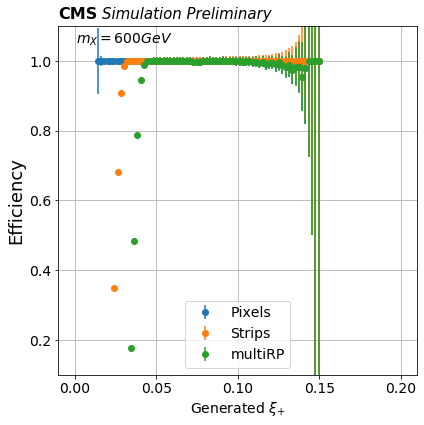

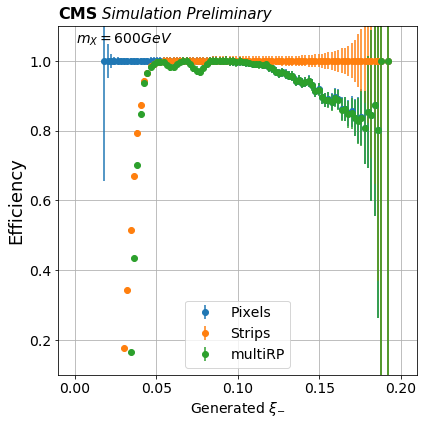

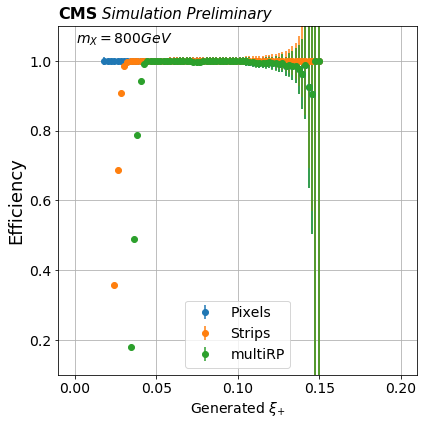

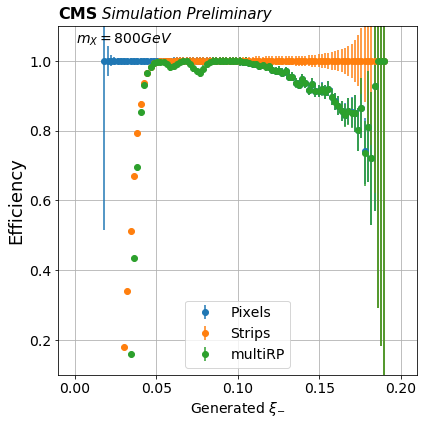

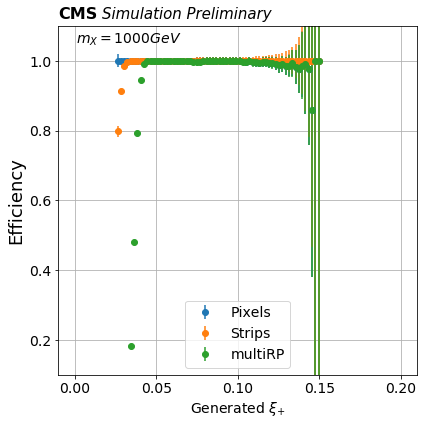

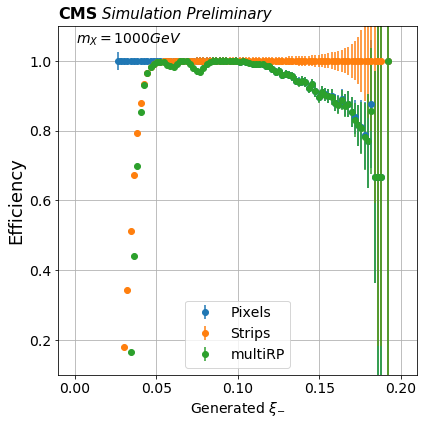

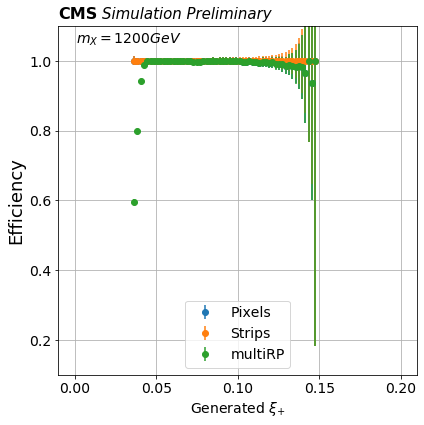

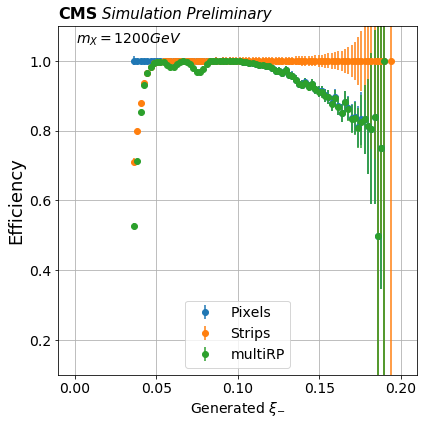

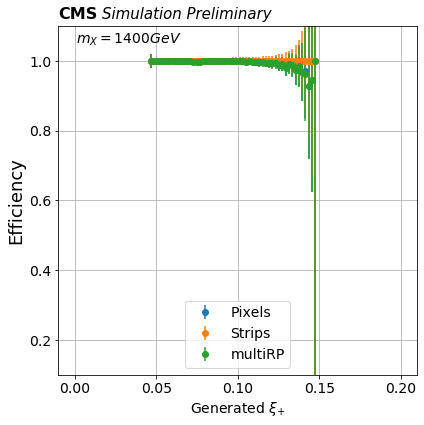

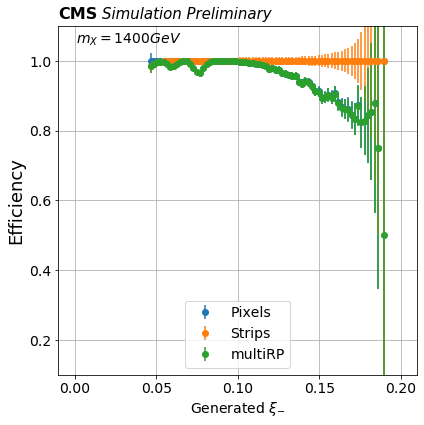

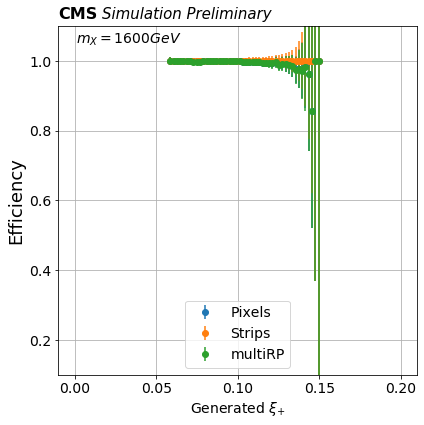

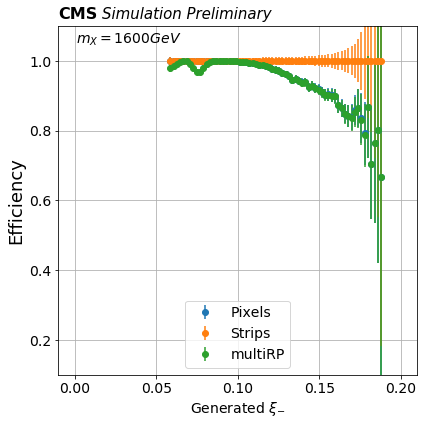

In [5]:
# display plots (reads always from the pickle file)

with open(os.path.join(outdir,'effgrs.pck'),'rb') as fin:
    x=pickle.load(fin)
    effGrs=pickle.load(fin)
    
keys=list(itertools.product(masses,sides))
for k in keys:
    
    mX,side=k
    
    effList=[]
    titleList=[]
    for a in ['pix','strip','multi']:
        grk=(mX,side,a)
        effList.append(effGrs[grk])
        titleList.append(titles[a])        
        
    showEfficiencies(x,
                     effList,
                     titleList,
                     xtitle=r'Generated $\xi_{%s}$'%('+' if side=='Pos' else '-'),
                     extraText=[r'$m_{X}=%d GeV$'%mX],
                     outpname=os.path.join(outdir,'rpeff_{0}_{1}'.format(mX,side)),
                     ylim=(0.1,1.1)
                    )    


## Combined PPS efficiency plots

In [6]:
def fillCombinedRPEffs():
    
    """ fill the combined PPS efficiency graphs (just needs to be done once, as it'll store the results in a pickle file) """

    combineEffGrs={}
    
    keys=list(itertools.product(masses,algos,vlist))
    for k in keys:
        mX,algo,v=k    
    
        combineEffGrs[k] = getEfficiency(df,
                                         baseCut=((df['mX']==mX) & (df['csiPos_gen']>0) & (df['csiNeg_gen']>0)),
                                         passCut=(df['mpp_%s'%algo]>0),
                                         vname='{0}_gen'.format(v),
                                         wname='wgt',
                                         hbins=effbins[v])
        
    pckF=os.path.join(outdir,'combeffgrs.pck')
    with open(pckF,'wb') as fout:
        pickle.dump(effbins,fout,pickle.HIGHEST_PROTOCOL)
        pickle.dump(combineEffGrs,fout,pickle.HIGHEST_PROTOCOL)
    
    print('Results saved in',pckF)

if fillGraphs: fillCombinedRPEffs()     

/usr/local/bin/start_ipykernel.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/bin/start_ipykernel.py:29: RuntimeWarning: divide by zero encountered in log


Results saved in /eos/user/p/psilva/www/ExclusiveAna_2017_unblind_multi/rpeff/combeffgrs.pck


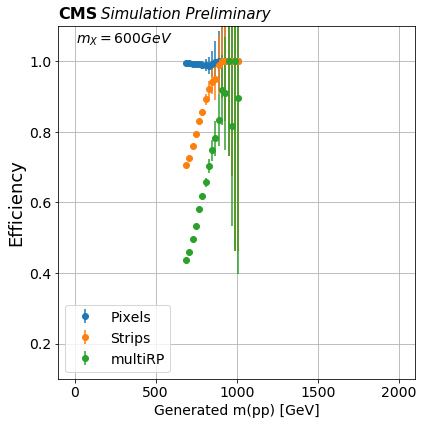

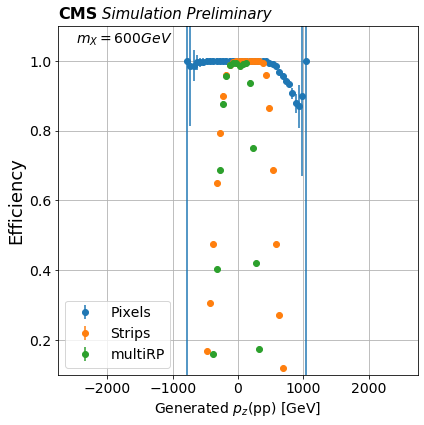

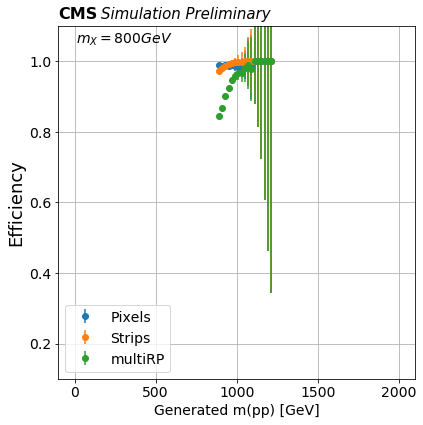

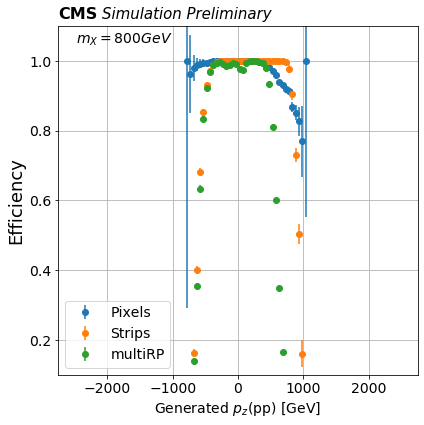

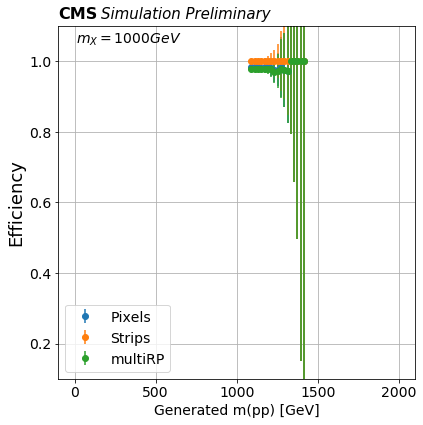

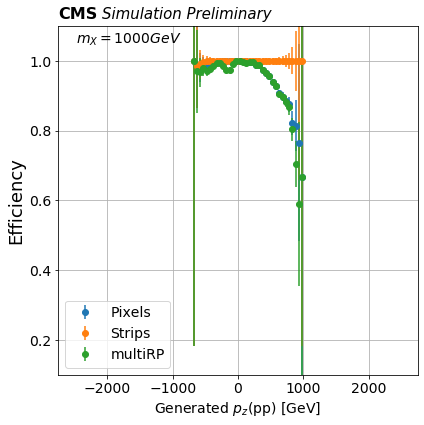

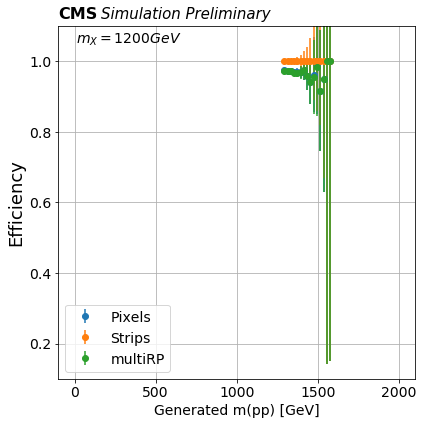

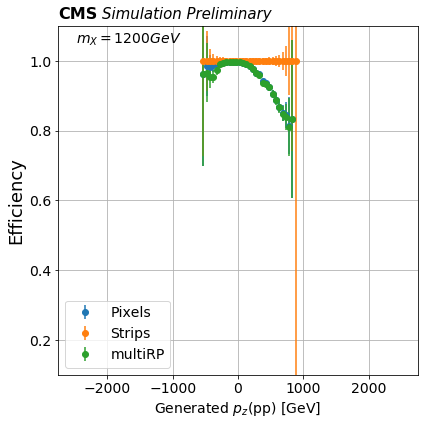

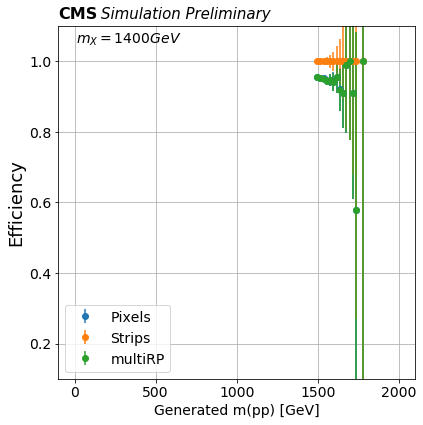

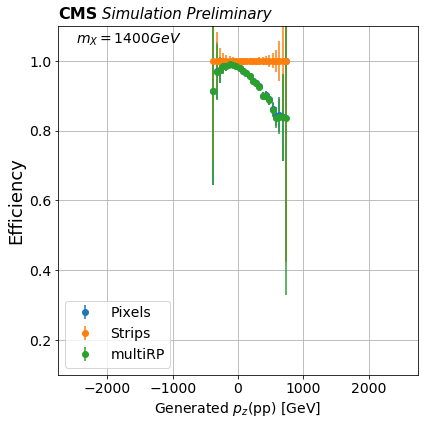

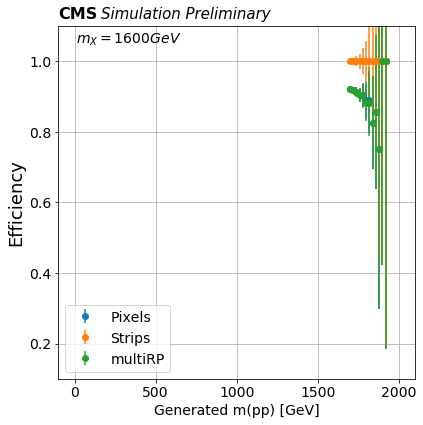

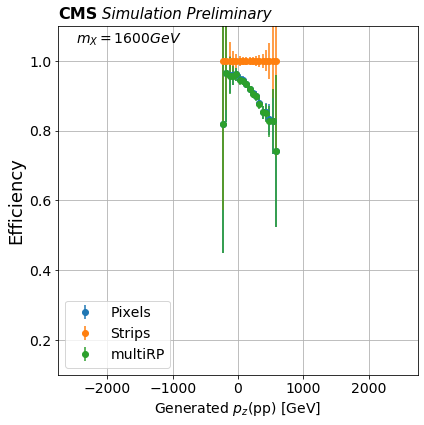

In [7]:
with open(os.path.join(outdir,'combeffgrs.pck'),'rb') as fin:
    x=pickle.load(fin)
    effGrs=pickle.load(fin)
    
keys=list(itertools.product(masses,vlist))
for k in keys:
    
    mX,v=k
    
    effList=[]
    titleList=[]
    for a in ['pix','strip','multi']:
        grk=(mX,a,v)
        effList.append(effGrs[grk])
        titleList.append(titles[a])        
        
    showEfficiencies(effbins[v],
                     effList,
                     titleList,
                     xtitle=r'Generated %s'%vtitles[v],
                     extraText=[r'$m_{X}=%d GeV$'%mX],
                     outpname=os.path.join(outdir,'combrpeff_{0}_{1}'.format(mX,v)),
                     ylim=(0.1,1.1),
                     loc='lower left'
                    )

## Resolution plots

/usr/local/bin/start_ipykernel.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



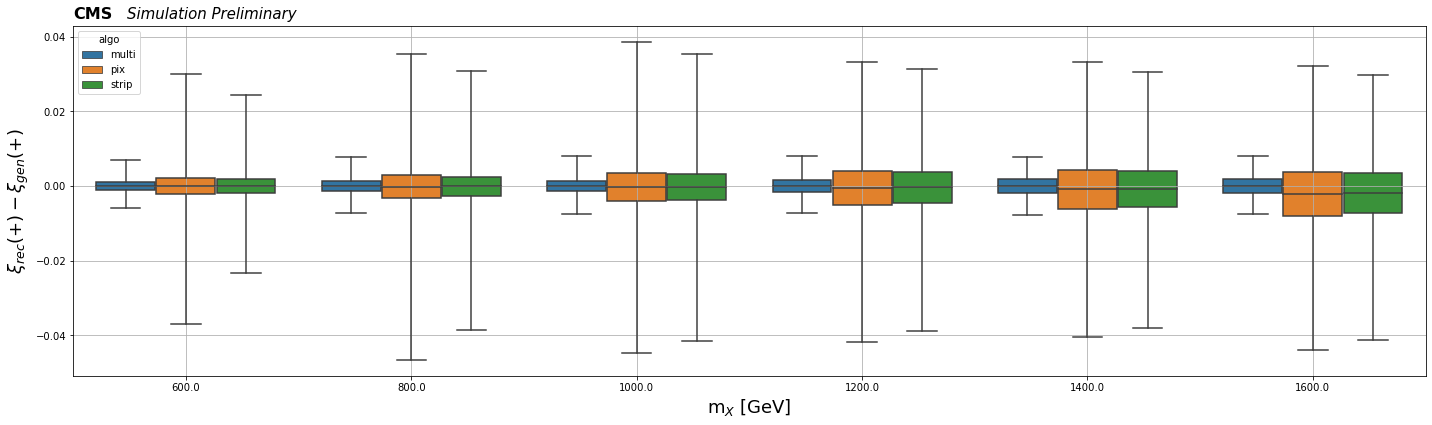

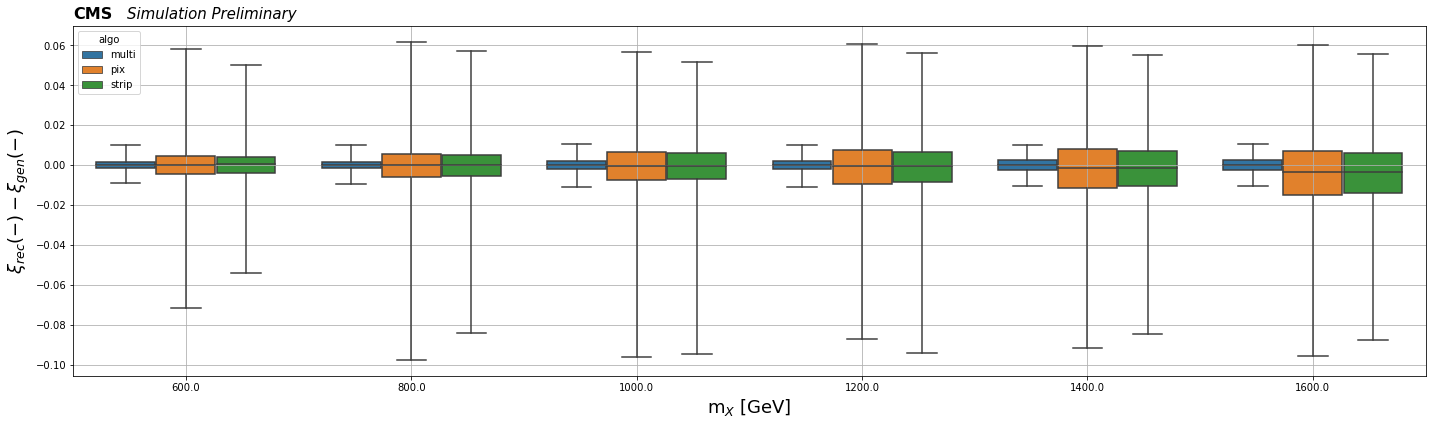

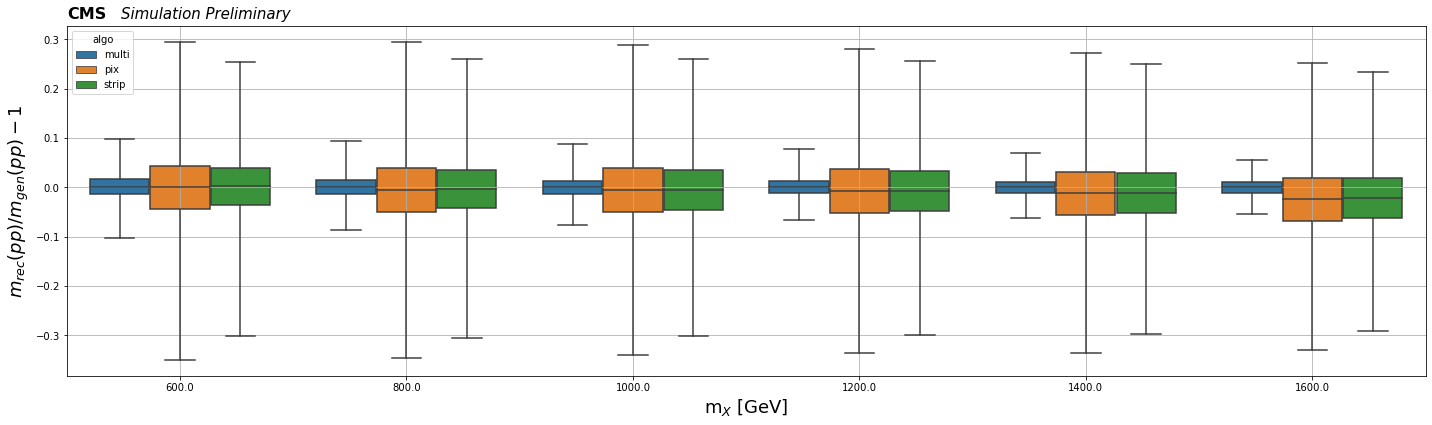

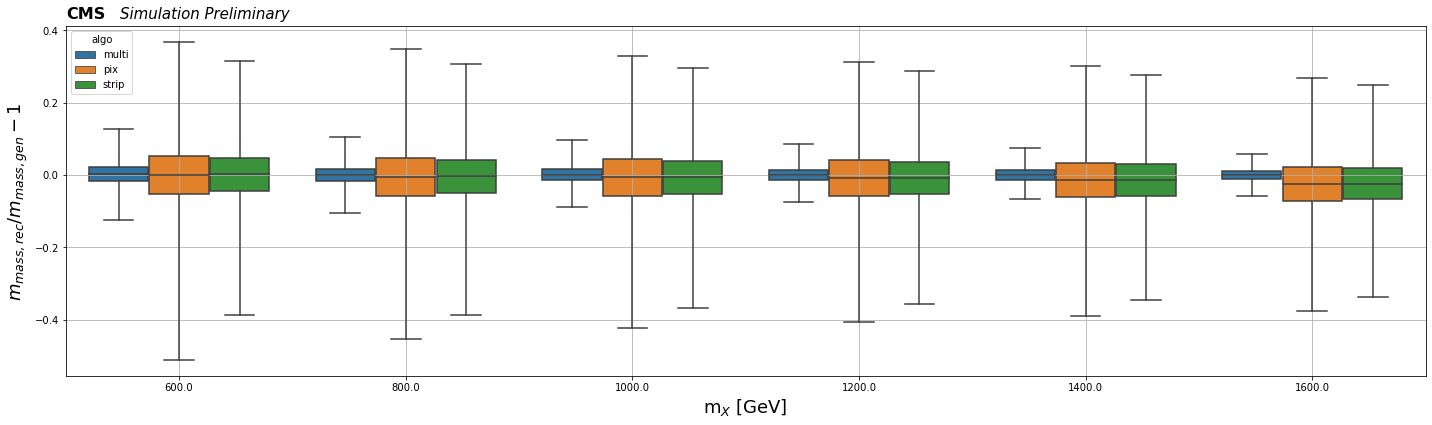

In [9]:
def fillResolutions():
    
    """ fill the combined PPS efficiency graphs (just needs to be done once, as it'll store the results in a pickle file) """

    resolSummary=[]
    
    for a in algos:
        
        #compute resolutions per algo
        resolSummary.append( df[['mX','csiPos_%s'%a,'csiNeg_%s'%a]].copy() )
        resolSummary[-1]['algo']      = a
        resolSummary[-1]['resCsiPos'] = df['csiPos_%s'%a]-df['csiPos_gen']
        resolSummary[-1]['resCsiNeg'] = df['csiNeg_%s'%a]-df['csiNeg_gen']
        resolSummary[-1]['resMpp']    = df['mpp_%s'%a]/df['mpp_gen']-1
        resolSummary[-1]['resMmass']  = df['mmass_%s'%a]/df['mmass_gen']-1

        #require both arms in acceptance
        mask=(resolSummary[-1]['csiPos_%s'%a]>0) & (resolSummary[-1]['csiNeg_%s'%a]>0)
        resolSummary[-1]=resolSummary[-1][mask]
                
    return pd.concat(resolSummary, ignore_index=True)

resolSummary = fillResolutions()   

#show the summaries as box plots
for var,varTitle in [('resCsiPos', r'$\xi_{rec}(+)-\xi_{gen}(+)$'),
                     ('resCsiNeg', r'$\xi_{rec}(-)-\xi_{gen}(-)$'),
                     ('resMpp',    r'$m_{rec}(pp)/m_{gen}(pp)-1$'),
                     ('resMmass',  r'$m_{mass,rec}/m_{mass,gen}-1$'),
                    ]:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 6)
    g=sns.boxplot(x="mX",y=var, hue="algo",data=resolSummary, ax=ax, whis=np.inf)    
    ax.set_xlabel(r'm$_{X}$ [GeV]',fontsize=16)
    ax.xaxis.label.set_size(18)
    ax.set_ylabel(varTitle,fontsize=16)
    ax.yaxis.label.set_size(18)
    ax.text(0,   1.02,'CMS',                    transform=ax.transAxes, fontsize=16,weight='bold')
    ax.text(0.04,1.02,'Simulation Preliminary', transform=ax.transAxes, fontsize=15, style='italic')

    plt.grid(True)
    plt.tight_layout()

    for ext in ['png','pdf']:
        figName=os.path.join(outdir,'resol_{0}.{1}'.format(var,ext))
        plt.savefig( figName)
 
    plt.show()
        